# Tranfer Model
In this learning exercise, we will use VGG16 pretrained model.
Objective of this program is train a new model with the support from pretained model to reduce the training time and accuracy.

In this case, we will get the images on food and non-food.
https://lazyprogrammer.me/course_files/Food-5K.zip

Open questions:
  Check out what categories are supported by VGG model ?
  The new head ( a new model) can only support two classification.



**1. Make the data ready**

Download the data file
Check the directory struture.
Create a new data structure with the following specification:
  * data / training/test
  * data / training/non-food and data / training/food
  * data / validation/non-food and data / validation/food
Set up ImageDataGenerator:
*   train_gen
*   test_gen

provide all transformation for train_gen. for Test, we do not need
config train_gen with flow_from_directory

Use these generators into model fit_generator function

In [0]:
# imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# basic tensorflow
import tensorflow as tf


In [0]:
# check TF verion.
tf.__version__

'2.0.0'

In [0]:
# if the above returns 1.x, run the following command to install tensorflow 2.0 GPU version.
# And restart the runtime using menu.
# import tensorflow and re-run this commmand
!pip install -q tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 46kB/s 
     |████████████████████████████████| 450kB 40.7MB/s 
     |████████████████████████████████| 3.8MB 51.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.


In [0]:
# model
from tensorflow.keras.models import Model
# layers
from tensorflow.keras.layers import Input, Dense, Dropout, Activation

# optimizers
from tensorflow.keras.optimizers import SGD, Adam
# applications like VGG
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel , preprocess_input
# preprocessing with ImageDataGenerator 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# File system imports
from glob import glob
import sys
import os




In [0]:
# download the data (files)
!wget https://lazyprogrammer.me/course_files/Food-5K.zip



--2020-02-23 08:55:05--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  11.8MB/s    in 50s     

2020-02-23 08:55:56 (8.46 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [0]:
# check if the file is downloaded using ls command
!ls

Food-5K.zip  sample_data


In [0]:
# unzip this file.
!unzip -qq -o Food-5K.zip

In [0]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [0]:
!rm Food-5K

rm: cannot remove 'Food-5K': Is a directory


In [0]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

In [0]:
!mkdir data

In [0]:
!ls

data  Food-5K  Food-5K.zip  __MACOSX  sample_data


In [0]:
!mkdir data/training
!mkdir data/test
!mkdir data/training/nonfood
!mkdir data/training/food
!mkdir data/test/nonfood
!mkdir data/test/food



In [0]:
# move training daa into training floder 
!mv Food-5K/training/0*.jpg data/training/nonfood/
!mv Food-5K/training/1*.jpg data/training/food/

!mv Food-5K/validation/0*.jpg data/test/nonfood/
!mv Food-5K/validation/1*.jpg data/test/food/

# leave Food-5K/evaluation files as they are.


In [0]:
!ls Food-5K/training/

In [0]:
train_path = "data/training"
test_path = "data/test"


In [0]:
images_files = glob(train_path+ "/*/*.jpg") #all the images : food and non-food
valid_images_files = glob(test_path+"/*/*.jpg") # test files
len(images_files)

3000

In [0]:
# identifing categorgies based on the number of folders. It will return 2 folders
# i.e two categories : food and non-food
folders = glob(train_path +"/*")
K = len(folders)
K

2

In [0]:
batch_size = 32     # 128
IMAGE_SIZE = [200,200]


In [0]:
# Build two image generators:

# generators have two steps: 1) Tranformations and 2 configuration 

# training_gen
# keep a note on preprocess_input which has come from applications.vgg16 module.
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)



In [0]:
training_generator = train_gen.flow_from_directory(
    directory = train_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle=True,
)

Found 3000 images belonging to 2 classes.


In [0]:
# note that we do not need to augment data with various transformation since we will not use during the training.
# even for prediction or evaluation, we will use files directly expect for the image size should be the same size
# which the model will expect
test_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [0]:
test_generator = test_gen.flow_from_directory(
    directory = test_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
 )
#  shuffle=True is not required.


Found 1000 images belonging to 2 classes.


**2. Build the model**

1.Get the pretainedmodel using preprocessing on VGG

Add the head such that output dimension is match with input for layer of the new model.

Set up last layers with K dimention with Softmax function.

2. Compile the model (adam, categorical_crossentropy, accuracy)

3. Call model.fit-generator(train and test generators, epchos, batch_size)


In [0]:
# pre-trained model
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3], # expected size of image. do not have a standard output size?
    weights="imagenet",
    include_top = False
)

In [0]:
!ls


data  Food-5K  Food-5K.zip  __MACOSX  sample_data


In [0]:
#make ptm non-trainable
ptm.trainable = False


In [0]:
# define the layers for the head and attach the output of PTM (Pretrained model) to the new model.
from tensorflow.keras.layers import Flatten
x = Flatten()(ptm.output)
x = Dense(K,activation="softmax")(x)


In [0]:
# define the model combine new layers and PTM
model = Model(ptm.input,x)

define the loss function

In [0]:
model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)


In [0]:
# summary of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

**3. Train the model**

In [0]:
r = model.fit_generator(
    generator = training_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch = int(np.ceil(len(images_files) / batch_size)),
    validation_steps = int(np.ceil(len(valid_images_files) / batch_size)),
)



Epoch 1/10
94/94 [==============================] - 80s 848ms/step - loss: 0.6696 - accuracy: 0.9440 - val_loss: 0.4045 - val_accuracy: 0.9660
Epoch 2/10
94/94 [==============================] - 75s 800ms/step - loss: 0.4950 - accuracy: 0.9623 - val_loss: 0.3545 - val_accuracy: 0.9730
Epoch 3/10
94/94 [==============================] - 76s 807ms/step - loss: 0.4577 - accuracy: 0.9693 - val_loss: 0.3694 - val_accuracy: 0.9760
Epoch 4/10
94/94 [==============================] - 76s 809ms/step - loss: 0.3836 - accuracy: 0.9733 - val_loss: 0.3574 - val_accuracy: 0.9780
Epoch 5/10
94/94 [==============================] - 76s 808ms/step - loss: 0.3704 - accuracy: 0.9740 - val_loss: 0.3055 - val_accuracy: 0.9790
Epoch 6/10
94/94 [==============================] - 76s 808ms/step - loss: 0.3812 - accuracy: 0.9737 - val_loss: 0.3066 - val_accuracy: 0.9790
Epoch 7/10
94/94 [==============================] - 76s 811ms/step - loss: 0.3327 - accuracy: 0.9770 - val_loss: 0.2876 - val_accuracy: 0.9800

**4. Evaluate the model using the train data without data augmentation**

In [0]:
# develop another train generator without any tranformation for evaluation
evaluation_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input
)

evaluation_generator = test_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
)


Found 3000 images belonging to 2 classes.


In [0]:
model.evaluate_generator(
    evaluation_generator,
    steps=int(np.ceil(len(images_files) / batch_size)))

[0.26225290079883495, 0.983]

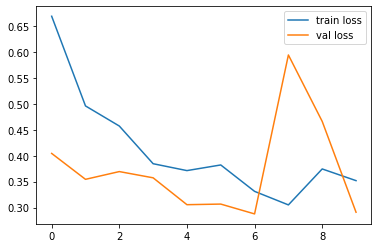

In [0]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

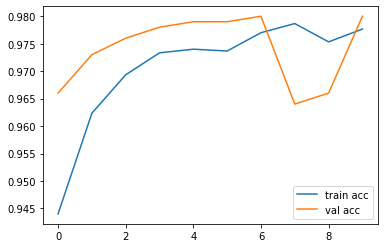

In [0]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

Check why missclassification happen and what could be the reasons.